# Mini-Project Numerical Scientific Computing

- Understand the mathematical algorithm and how it can be programmed.
- Naive algorithm: Make a first implementation in Python using for-loops. You can use either lists or numpy arrays for data storage, but no vector operations.
- Numpy vectorized algorithm: Instead of looping over every element, use Numpy vectorized operations.

# Importing libraries


In [73]:
# Importing libraries
import matplotlib.pyplot as plt
import multiprocessing as mp
from numba import jit
import numpy as np
import cv2 as cv
import timeit
import time

# Set the threshold to a high value to display all elements
np.set_printoptions(threshold=np.inf)

# Naive algorithm for computing Mandelbrot set


##### Naive Mandelbrot Algorithm


In [74]:
def NaiveMandelbrot(width, height, img, params):
    # Pseudocode from wikipedia: https://en.wikipedia.org/wiki/Mandelbrot_set
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params
   
    # Iterate through each pixel coordinate
    for Px in range(width):
        for Py in range(height):
            # Map pixel coordinates to real and imaginary parts of c
            c_Real = min_real + (max_real - min_real) * (Px / width)
            c_Imgy = min_imaginary + (max_imaginary - min_imaginary) * (Py / height)

            # Initialize z as 0
            z_Real = 0
            z_Imgy = 0

            # Initialize iterations
            iter = 0

            # Calculate the Mandelbrot iteration until the threshold
            # has been reached at 2 and iterations reach max iterations.
            # The threshold has been reached when the magnitude at each
            # calculation is <= to 2. (2*2) represent the squared threshold.
            while z_Real * z_Real + z_Imgy * z_Imgy <= T*2 and iter < max_iter:
                # Calculate the next iteration of the real and imginary part of z
                next_z_Real = z_Real * z_Real - z_Imgy * z_Imgy + c_Real
                next_z_Imgy = 2 * z_Real * z_Imgy + c_Imgy
                
                # Assign the calculated parts to z as the new starting point
                z_Real = next_z_Real
                z_Imgy = next_z_Imgy

                # Increase iteration
                iter += 1

            # Checking if i(c) is in the Mandelbrot set
            if iter == max_iter:
                # In the Mandelbrot set
                color = 255
                img[Py, Px] = color
            else:
                # Paint the pixel based on gradient color
                color = plt.cm.hot(iter / max_iter)
                img[Py, Px] = (color[0] * 255, color[1] * 255, color[2] * 255)
    
    return img

# Optimizing the inner while loop


##### Optimized Mandelbrot Algorithm+


In [75]:
def NaiveMandelbrotOptimized(width, height, img, params):
    # Pseudocode from wikipedia: https://en.wikipedia.org/wiki/Plotting_algorithms_for_the_Mandelbrot_set
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params

    # Iterate through each pixel coordinate
    for Px in range(width):
        for Py in range(height):
            # Map pixel coordinates to real and imaginary parts of c
            c_Real = min_real + (max_real - min_real) * (Px / width)
            c_Imgy = min_imaginary + (max_imaginary - min_imaginary) * (Py / height)

            # Initialize z as 0 and introduce new variable w
            z_Real = 0
            z_Imgy = 0
            w = 0

            # Initialize iterations
            iter = 0

            # Calculate the Mandelbrot iteration until the threshold
            # Optimizing multiplication computations
            # from naive approach
            while z_Real + z_Imgy <= T*2 and iter < max_iter:
                # Calculate the next iteration of the real and imginary part of z
                next_z_Real = z_Real - z_Imgy + c_Real
                next_z_Imgy = w - z_Real - z_Imgy + c_Imgy

                # Assign the calculated parts to z as the new starting point
                z_Real = next_z_Real * next_z_Real
                z_Imgy = next_z_Imgy * next_z_Imgy
                w = (next_z_Real + next_z_Imgy) * (next_z_Real + next_z_Imgy)

                # Increase iteration
                iter += 1

            # Checking if i(c) is in the Mandelbrot set
            if iter == max_iter:
                # In the Mandelbrot set
                img[Py, Px] = 255
            else:
                # Paint the pixel based on gradient color
                color = plt.cm.hot(iter / max_iter)
                img[Py, Px] = (color[0] * 255, color[1] * 255, color[2] * 255)

    return img

##### Further Optimized Mandelbrot Algorithm++


In [76]:
def NaiveMandelbrotOptimizedPlus(width, height, img, params):
    # Pseudocode from wikipedia: https://en.wikipedia.org/wiki/Plotting_algorithms_for_the_Mandelbrot_set
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params

    # Iterate through each pixel coordinate
    for Px in range(width):
        for Py in range(height):
            # Map pixel coordinates to real and imaginary parts of c
            c_Real = min_real + (max_real - min_real) * (Px / width)
            c_Imgy = min_imaginary + (max_imaginary - min_imaginary) * (Py / height)

            # Initialize z as 0
            z_Real = 0
            z_Imgy = 0

            next_z_Real = 0
            next_z_Imgy = 0

            # Initialize iterations
            iter = 0

            # Calculate the Mandelbrot iteration until the threshold
            # Optimizing multiplication computations
            # from naive approach
            while z_Real + z_Imgy <= T*2 and iter < max_iter:
                # Calculate the next iteration of the real and imginary part of z
                next_z_Imgy = 2 * next_z_Real * next_z_Imgy + c_Imgy
                next_z_Real = z_Real - z_Imgy + c_Real

                # Assign the calculated parts to z as the new starting point
                z_Real = next_z_Real * next_z_Real
                z_Imgy = next_z_Imgy * next_z_Imgy

                # Increase iteration
                iter += 1

            # Checking if i(c) is in the Mandelbrot set
            if iter == max_iter:
                # In the Mandelbrot set
                img[Py, Px] = 255
            else:
                # Paint the pixel based on gradient color
                color = plt.cm.hot(iter / max_iter)
                img[Py, Px] = (color[0] * 255, color[1] * 255, color[2] * 255)

    return img

# Mandelbrot algorithm using Numpy vectorization


Performing vectorization on the naive Mandelbrot Algorithm implementation


In [77]:
def VectorizedMandelbrot(width, height, img, params):
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params

    # Creating np arrays for width/height pixels
    Px = np.linspace(min_real, max_real, width)
    Py = np.linspace(min_imaginary, max_imaginary, height)
    c = Px[np.newaxis, :] + 1j * Py[:, np.newaxis]
    
    # Initialize z as 0's, iter, and mask arrays
    z = np.zeros_like(c, dtype=np.complex128)
    iter = np.zeros(c.shape, dtype=np.int32)
    mask = np.full(c.shape, True, dtype=bool)

    # Using logical mask to check for divergence or escaped points
    for i in range(int(max_iter)):
        z[mask] = z[mask] * z[mask] + c[mask]
        mask = np.logical_and(mask, np.abs(z) < T)
        iter[mask] = i
    
    # If a point hasn't diverged, set the output value to (max iter - 1)
    #iter[mask] = max_iter - 1

    # Assigning colors based on escape status and iterations
    colors = plt.cm.hot(iter / max_iter)
    
    img[:, :, 0] = colors[:,:, 0] * 255
    img[:, :, 1] = colors[:,:, 1] * 255
    img[:, :, 2] = colors[:,:, 2] * 255
    
    return img

# Naive Mandelbrot Algorithm using Numba jit


In [78]:
@jit(nopython=True, fastmath=True, cache=True)
def NaiveMandelbrotNumba(width, height, img, params):
    # Pseudocode from wikipedia: https://en.wikipedia.org/wiki/Mandelbrot_set
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params

    # Iterate through each pixel coordinate
    # t1 = time.time()
    for Px in range(width):
        for Py in range(height):
            # Map pixel coordinates to real and imaginary parts of c
            c_Real = min_real + (max_real - min_real) * (Px / width)
            c_Imgy = min_imaginary + (max_imaginary - min_imaginary) * (Py / height)

            # Initialize z as 0
            z_Real = 0
            z_Imgy = 0

            # Initialize iterations
            iter = 0

            # Calculate the Mandelbrot iteration until the threshold
            # has been reached at 2 and iterations reach max iterations.
            # The threshold has been reached when the magnitude at each
            # calculation is <= to 2. (2*2) represent the squared threshold.
            while z_Real**2 + z_Imgy**2 <= T*2 and iter < max_iter:
                # Calculate the next iteration of the real and imginary part of z
                next_z_Real = z_Real**2 - z_Imgy**2 + c_Real
                next_z_Imgy = 2 * z_Real * z_Imgy + c_Imgy

                # Assign the calculated parts to z as the new starting point
                z_Real = next_z_Real
                z_Imgy = next_z_Imgy

                # Increase iteration
                iter += 1

            # Checking if i(c) is in the Mandelbrot set
            if iter == max_iter:
                # In the Mandelbrot set
                img[Py, Px] = 255
            else:
                # Paint the pixel based on simple color mapping
                i = iter / max_iter
                r = int(255 * (1 - i))
                g = int(255 * (1 - 0.5 * i))
                b = int(255 * (1 - 0.75 * i))
                img[Py, Px] = (r * 255, g * 255, b * 255)
    # t2 = time.time()

    # print(f"\n- Naive Mandelbrot Algorithm -\nExecution time: {t2-t1}s")

    return img

# Parallel Mandelbrot Algorithm

In [79]:
def MandelbrotChunk(chunk_start, chunk_end, width, height, params):
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T, *_ = params

    # Compute Mandelbrot set for a chunk of the image
    # Iterate through pixels from chunk_start to chunk_end
    # Update image array accordingly
    
    # Initialize an empty array to store the chunk
    chunk = np.zeros((chunk_end - chunk_start, width, 3), dtype=np.uint8)

    # Iterating through a chunk of the image
    for Px in range(width):
        for Py in range(chunk_start, chunk_end):
            # Map pixel coordinates to real and imaginary parts of c
            c_Real = min_real + (max_real - min_real) * (Px / width)
            c_Imgy = min_imaginary + (max_imaginary - min_imaginary) * (Py / height)

            # Initialize z as 0
            z_Real = 0
            z_Imgy = 0

            # Initialize iterations
            iter = 0

            # Calculate the Mandelbrot iteration until the threshold
            # has been reached at 2 and iterations reach max iterations.
            # The threshold has been reached when the magnitude at each
            # calculation is <= to 2. (2*2) represent the squared threshold.
            while z_Real * z_Real + z_Imgy * z_Imgy <= T * 2 and iter < max_iter:
                # Calculate the next iteration of the real and imginary part of z
                next_z_Real = z_Real * z_Real - z_Imgy * z_Imgy + c_Real
                next_z_Imgy = 2 * z_Real * z_Imgy + c_Imgy

                # Assign the calculated parts to z as the new starting point
                z_Real = next_z_Real
                z_Imgy = next_z_Imgy

                # Increase iteration
                iter += 1

            # Checking if i(c) is in the Mandelbrot set
            if iter == max_iter:
                # In the Mandelbrot set
                color = 255
                chunk[Py - chunk_start, Px] = color
            else:
                # Paint the pixel based on gradient color
                color = plt.cm.hot(iter / max_iter)
                chunk[Py - chunk_start, Px] = (color[0] * 255, color[1] * 255, color[2] * 255)

    return chunk

def chunking(check, num_processes):
    if check == "equal":
        # Dividing image in equal chunks based on number of processes
        chunk_size = height // num_processes
        chunks = [(i * chunk_size, (i + 1) * chunk_size) for i in range(num_processes)]
        
        # If the last chunk size != height, we add the remainder of pixels to the last chunk
        if chunks[-1][1] != height:
           chunks[-1] = (chunks[-1][0], height)
           
        return chunks
    
    elif check == "dynamic":
        # Using dynamic chunking based on number of processed and image size
        avg_chunk_size = height / num_processes
        remaining_height = height % num_processes
        chunks = []
        start = 0
        
        # Check if remaining height is less than numnber of processes
        # if yes, increase chunk size for making even chunks
        for i in range(num_processes):
            chunk_size = int(avg_chunk_size)
            if i < remaining_height:
                chunk_size += 1
            end = start + chunk_size
            chunks.append((start, end))
            start = end
            
        return chunks
    else:
        print("Error! *Wrong parameter*")
    

def ParallelMandelbrot(width, height, img, params):
    *_, check, P = params
    
    # Create process pool and apply chunking scheme
    pool = mp.Pool(processes=P)
    chunks = chunking(check, P)
    print("type:", check)
    print("processes:", P)
    print("chunks",chunks)
    
    # Assigning a chunk to each process
    results = []
    t1 = time.time()
    for chunk_start, chunk_end in chunks:
        results.append(pool.apply_async(MandelbrotChunk, (chunk_start, chunk_end, width, height, params)))
    
    # Combine each image chunk to create full image
    for result, (chunk_start, chunk_end) in zip(results, chunks):
        img[chunk_start:chunk_end] = result.get()
    
    # Close and wait for process termination -> Good practice!
    pool.close()
    pool.join()
    
    t2 = time.time()
    t = t2-t1
    print("time:",t)
    print()
    
    return img, t

def plot_results(P_values, time_values, chunk): 
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Performance Analysis of Parallel Mandelbrot Algorithm\nChunking: {chunk}", fontsize=16)

    axs[0].set_title(f"Execution Time")
    axs[0].plot(P_values, time_values, marker='o', color='b')
    axs[0].set_xlabel("Number of Processes")
    axs[0].set_ylabel("Execution Time [s]")

    speedup = [time_values[0] / t for t in time_values]
    axs[1].set_title(f"Speedup")
    axs[1].plot(P_values, speedup, marker='o', color='r')
    axs[1].set_xlabel("Number of Processes")
    axs[1].set_ylabel("Speedup")

    plt.tight_layout()
    plt.show()

# Displaying the Mandelbrot set in the complex plane


##### Function to display Mandelbrot


In [80]:
def displayMandelbrot(img, params, title, cmap=None):
    min_real, max_real, min_imaginary, max_imaginary, *_ = params
    plt.imshow(img, extent=(min_real, max_real, min_imaginary, max_imaginary), cmap=cmap)
    plt.xlabel("Real(c)")
    plt.ylabel("Imaginary(c)")
    plt.title("Mandelbrot Set\n- " + f"{title}")
    plt.show()

# Defining image and complex variables


In [81]:
# Defining image size
width = 100
height = 100
channel = 3
img = np.zeros((height, width, 3), dtype=np.uint8)

# Defining max iterations
max_iter = 100.0

# Defining threshold
T = 2.0

# Defining the range of values for
# the real and imaginary parts of c
min_real = -2.0
max_real = 1.0
min_imaginary = -1.5
max_imaginary = 1.5
#params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T]
params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T, 4]

chunk_start 0
chunk_end 25
chunk_start 25
chunk_end 50


chunk_start 50
chunk_end 75
chunk_start 75
chunk_end 100
time: 0.4369218349456787 s

- Naive Mandelbrot Algorithm -


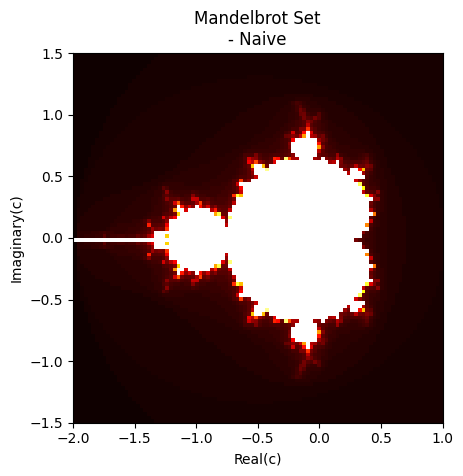

In [82]:
if __name__ == "__main__":
    processes = mp.cpu_count()
    P_values = range(1, processes+1)
    times1 = []
    times2 = []
    for i in range(processes):
        params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T, "equal", i+1]
        
        _, t = ParallelMandelbrot(width, height, img, params)
        times1.append(t)
        
        params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T, "dynamic", i+1]
        
        img, t = ParallelMandelbrot(width, height, img, params)
        times2.append(t)
        
    print(f"\nChunking: Equal\nTotal Time: {np.array(times1).sum()}")
    print(f"\nChunking: Dynamic\nTotal Time: {np.array(times2).sum()}")
    
    displayMandelbrot(img, params, "Parallel")
    
    plot_results(P_values, times1, "equal")
    plot_results(P_values, times2, "dynamic")

### Running algorithms


time: 0.34984350204467773 s

- Naive Mandelbrot Algorithm -


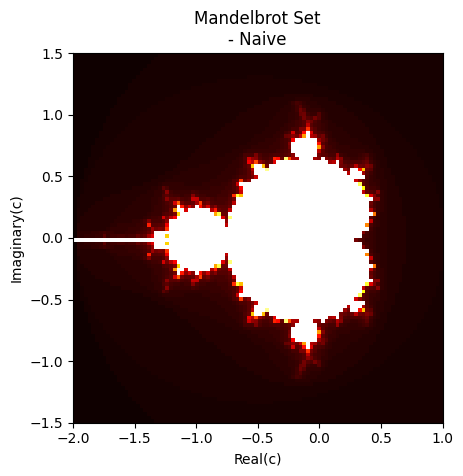


- Optimized Naive Mandelbrot Algorithm+ -


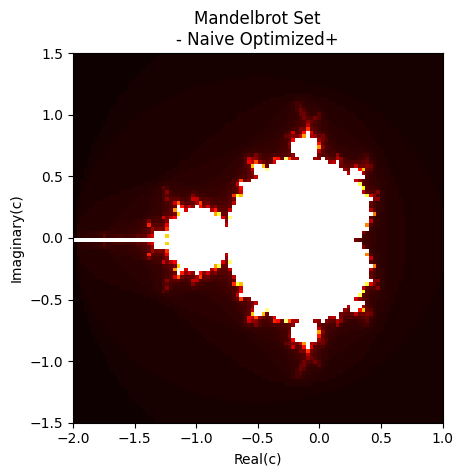


- Optimized Naive Mandelbrot Algorithm++ -


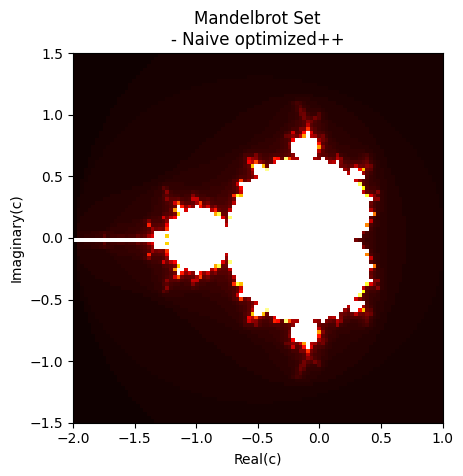


- Vectorized Mandelbrot Algorithm -


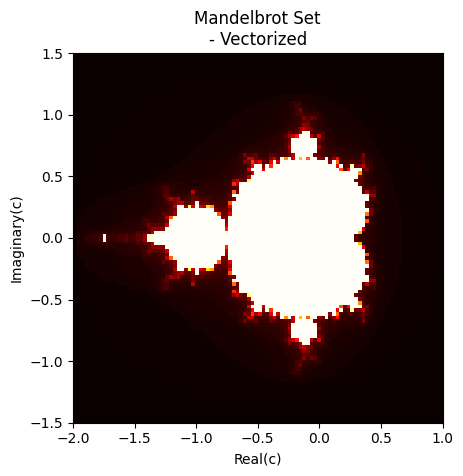


- Numba Mandelbrot Algorithm -


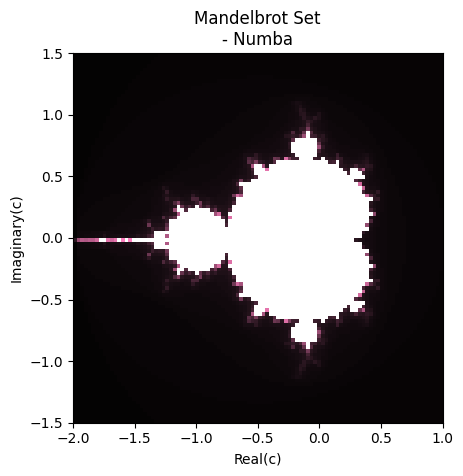

In [83]:
params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T]
# Naive Mandelbrot Algorithm
t1 = time.time()
img_mandel = NaiveMandelbrot(width, height, img, params)
print("time:",time.time() - t1, "s")
print(f"\n- Naive Mandelbrot Algorithm -")
displayMandelbrot(img_mandel, params, "Naive")

# Optimized Mandelbrot Algorithm+
img_mandel = NaiveMandelbrotOptimized(width, height, img, params)
print(f"\n- Optimized Naive Mandelbrot Algorithm+ -")
displayMandelbrot(img_mandel, params, "Naive Optimized+")

# Optimized Mandelbrot Algorithm++
img_mandel = NaiveMandelbrotOptimizedPlus(width, height, img, params)
print(f"\n- Optimized Naive Mandelbrot Algorithm++ -")
displayMandelbrot(img_mandel, params, "Naive optimized++")

# Vectorized Mandelbrot Algorithm
img_mandel = VectorizedMandelbrot(width, height, img, params)
print(f"\n- Vectorized Mandelbrot Algorithm -")
displayMandelbrot(img_mandel, params, "Vectorized")

# Numba jit Optimized Mandelbrot Algorithm
img_mandel1 = NaiveMandelbrotNumba(width, height, img, params)
print(f"\n- Numba Mandelbrot Algorithm -")
displayMandelbrot(img_mandel1, params, "Numba", "hot")

### Timing each algorithm

In [84]:
# Number of runs
runs = 1

# Naive Mandelbrot Algorithm
#avg_time = timeit.timeit(lambda:NaiveMandelbrot(width, height, img, params), number = runs) / runs
#print(f"Naive Algorithm - Avg Execution Time: {avg_time}s")

# Optimized Mandelbrot Algorithm+
#avg_time = timeit.timeit(lambda:NaiveMandelbrotOptimized(width, height, img, params), number = runs) / runs
#print(f"Optimized+ Algorithm - Avg Execution Time: {avg_time}s")

# Optimized Mandelbrot Algorithm++
#avg_time = timeit.timeit(lambda:NaiveMandelbrotOptimizedPlus(width, height, img, params), number = runs) / runs
#print(f"Optimized++ Algorithm - Avg Execution Time: {avg_time}s")

# Vectorized Mandelbrot Algorithm
avg_time = timeit.timeit(lambda:VectorizedMandelbrot(width, height, img, params), number = runs) / runs
print(f"Vectorized Algorithm - Avg Execution Time: {avg_time}s")

# Numba jit Optimized Mandelbrot Algorithm
avg_time = timeit.timeit(lambda:NaiveMandelbrotNumba(width, height, img, params), number = runs) / runs
print(f"Numba Algorithm - Avg Execution Time: {avg_time}s")

Vectorized Algorithm - Avg Execution Time: 0.007941499818116426s
Numba Algorithm - Avg Execution Time: 0.0006238999776542187s
